This is my first time participating in a segmentation task competition.
Please point out any problems with my code in the comments, as I want to make my code better.
Also, please feel free to ask me any questions you may have.


My code is to divide a 65 channel image into several 512*512 blocks and infer block by block.
I don't want to train on blocks that have all 0 mask values.

In [1]:
import socket
import sys


is_train = _dh != ["/kaggle/working"]


NB = "exp0006"
HOST = "54a2c6eb5b61"


NB, HOST

('exp0006', '54a2c6eb5b61')

In [2]:
!nvidia-smi

Sun Mar 19 04:54:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import gc
import glob
import math
import os
import pickle
import random
import shutil
import warnings
from collections import OrderedDict
from pathlib import Path

import albumentations as albu
import cv2
import matplotlib.pyplot as plt

# import mlflow
import numpy as np
import pandas as pd
import timm
import torch
import torch.optim as optim
#from logzero import logger
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.simplefilter("ignore")

if is_train:
    ROOT_DIR = Path("../")
    DATA_DIR = ROOT_DIR / "data"
    OUTPUT_DIR = ROOT_DIR / "output"
    CP_DIR = OUTPUT_DIR
else:
    ROOT_DIR = Path("../")
    DATA_DIR = Path("/kaggle/input/vesuvius-challenge-ink-detection")
    OUTPUT_DIR = Path("./")
    CP_DIR = Path("/kaggle/input/ink-model/")


def to_pickle(filename, obj):
    with open(filename, mode="wb") as f:
        pickle.dump(obj, f)


def unpickle(filename):
    with open(filename, mode="rb") as fo:
        p = pickle.load(fo)
    return p

In [4]:
import multiprocessing

print("cpu count:", multiprocessing.cpu_count())


class Config:
    N_FOLD = 5
    RANDOM_SATE = 42
    LR = 1.0e-05
    MAX_LR = 1.0e-5
    PATIENCE = 15
    EPOCH = 8
    BATCH_SIZE = 8
    IMG_SIZE = 512
    NUM_WORKERS = multiprocessing.cpu_count()


def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(seed=Config.RANDOM_SATE)

cpu count: 2


In [5]:
glob.glob(str(DATA_DIR / "*"))

['/kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv',
 '/kaggle/input/vesuvius-challenge-ink-detection/test',
 '/kaggle/input/vesuvius-challenge-ink-detection/train']

In [6]:
def rle(img, thr=0.5):
    flat_img = img.flatten()
    flat_img = np.where(flat_img > thr, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix

    return starts_ix, lengths


def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

# Load Data

In [7]:
if is_train:

    img1 = []
    for i in tqdm(range(65)):
        img1.append(cv2.imread(str(DATA_DIR / f"train/1/surface_volume/{i:02}.tif"), 0))

    img2 = []
    for i in tqdm(range(65)):
        img2.append(cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0))

    img3 = []
    for i in tqdm(range(65)):
        img3.append(cv2.imread(str(DATA_DIR / f"train/3/surface_volume/{i:02}.tif"), 0))

    img1 = np.stack(img1)
    img2 = np.stack(img2)
    img3 = np.stack(img3)

    img1_label = cv2.imread(str(DATA_DIR / f"train/1/inklabels.png"), 0)
    img2_label = cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0)
    img3_label = cv2.imread(str(DATA_DIR / f"train/3/inklabels.png"), 0)

    img1_mask = cv2.imread(str(DATA_DIR / f"train/1/mask.png"), 0)
    img2_mask = cv2.imread(str(DATA_DIR / f"train/2/mask.png"), 0)
    img3_mask = cv2.imread(str(DATA_DIR / f"train/3/mask.png"), 0)

# Train

In [8]:
def get_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        albu.Normalize(mean=[0], std=[1]),
    ]
    return albu.Compose(train_transform)


def get_test_augmentation():
    train_transform = [
        albu.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        albu.Normalize(mean=[0], std=[1]),
    ]
    return albu.Compose(train_transform)

In [9]:
class CVDataSet(Dataset):
    def __init__(self, imgs, transforms, labels=None, data_type=None, crop_size=256):
        self.crop_size = crop_size
        self.imgs = imgs
        self.transforms = transforms
        self.labels = labels
        self.data_type = data_type

        self.cell_counts = []
        for img in self.imgs:
            cell_count = math.ceil(img.shape[1] / self.crop_size) * math.ceil(
                img.shape[2] / self.crop_size
            )
            self.cell_counts.append(cell_count)

    def __len__(self):
        data_count = 0
        if self.data_type == "train":

            self.cell_id_maps = {}

            counter = 0
            for img_num, img in enumerate(self.imgs):

                cell_count = math.ceil(img.shape[1] / self.crop_size) * math.ceil(
                    img.shape[2] / self.crop_size
                )
                for cell_id in range(cell_count):
                    h_num = cell_id // math.ceil(
                        self.labels[img_num].shape[1] / self.crop_size
                    )
                    w_num = cell_id - (
                        h_num
                        * math.ceil(self.labels[img_num].shape[1] / self.crop_size)
                    )

                    cropped_img = self.labels[img_num][
                        h_num * self.crop_size : h_num * self.crop_size
                        + self.crop_size,
                        w_num * self.crop_size : w_num * self.crop_size
                        + self.crop_size,
                    ]

                    if cropped_img.sum() == 0:
                        continue

                    data_count += 1

                    self.cell_id_maps[counter] = (img_num, cell_id)
                    counter += 1

        else:

            for img in self.imgs:
                data_count += math.ceil(img.shape[1] / self.crop_size) * math.ceil(
                    img.shape[2] / self.crop_size
                )
        return data_count

    def calc_img_num(self, idx):
        cum_cell_count = 0
        for i, cell_count in enumerate(self.cell_counts):
            cum_cell_count += cell_count
            if idx + 1 <= cum_cell_count:
                return i, idx - (cum_cell_count - cell_count)

    def __getitem__(self, idx):
        if self.data_type == "train":
            img_num, cell_id = self.cell_id_maps[idx]
        else:
            img_num, cell_id = self.calc_img_num(idx)

        target_img = self.imgs[img_num]
        if self.data_type != "test":
            target_label = self.labels[img_num]

        # print(target_label.shape)
        target_img = np.moveaxis(target_img, 0, 2)
        # target_label = np.moveaxis(target_label, 0, 2)

        h_num = cell_id // math.ceil(target_img.shape[1] / self.crop_size)
        w_num = cell_id - (h_num * math.ceil(target_img.shape[1] / self.crop_size))

        cropped_img = target_img[
            h_num * self.crop_size : h_num * self.crop_size + self.crop_size,
            w_num * self.crop_size : w_num * self.crop_size + self.crop_size,
        ]

        if self.data_type in ["train", "valid"]:
            cropped_label = target_label[
                h_num * self.crop_size : h_num * self.crop_size + self.crop_size,
                w_num * self.crop_size : w_num * self.crop_size + self.crop_size,
            ]
            augmented = self.transforms(image=cropped_img, mask=cropped_label)
            img = augmented["image"]
            img = np.moveaxis(img, 2, 0)
            mask = augmented["mask"]
        else:
            augmented = self.transforms(image=cropped_img)
            img = augmented["image"]
            img = np.moveaxis(img, 2, 0)
            mask = -1

        return img, mask / 255

In [10]:
class CVNet(nn.Module):
    def __init__(self, num_classes):
        super(CVNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=65, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(
            in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1
        )

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
        )
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X)  # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(
            contracting_11_out
        )  # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(
            contracting_12_out
        )  # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(
            contracting_21_out
        )  # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(
            contracting_22_out
        )  # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(
            contracting_31_out
        )  # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(
            contracting_32_out
        )  # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(
            contracting_41_out
        )  # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out)  # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out)  # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(
            torch.cat((expansive_11_out, contracting_41_out), dim=1)
        )  # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out)  # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(
            torch.cat((expansive_21_out, contracting_31_out), dim=1)
        )  # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out)  # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(
            torch.cat((expansive_31_out, contracting_21_out), dim=1)
        )  # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out)  # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(
            torch.cat((expansive_41_out, contracting_11_out), dim=1)
        )  # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out)  # [-1, num_classes, 256, 256]
        return output_out

In [11]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, fold=""):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            logger.info(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            logger.info(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )

        # if os.path.exists(CP_DIR / f'checkpoint_{NB}_{fold}.pt'):
        #    shutil.move(CP_DIR / f'checkpoint_{NB}_{fold}.pt', CP_DIR / f'checkpoint_{NB}_{fold}-2.pt')
        torch.save(model.state_dict(), CP_DIR / f"{HOST}_{NB}_checkpoint_{fold}.pt")
        self.val_loss_min = val_loss

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
if is_train:
    data_set = []
    data_set.append(
        {
            "train_img": [img1, img2],
            "train_label": [img1_label, img2_label],
            "valid_img": [img3],
            "valid_label": [img3_label],
            "valid_mask": [img3_mask],
        }
    )

    data_set.append(
        {
            "train_img": [img1, img3],
            "train_label": [img1_label, img3_label],
            "valid_img": [img2],
            "valid_label": [img2_label],
            "valid_mask": [img2_mask],
        }
    )

    data_set.append(
        {
            "train_img": [img2, img3],
            "train_label": [img2_label, img3_label],
            "valid_img": [img1],
            "valid_label": [img1_label],
            "valid_mask": [img1_mask],
        }
    )

In [14]:
%%time
if is_train:
    for fold in range(0, 3):
        print(f"====== {fold} ======")

        net = CVNet(1)
        net.to(device)

        # criterion = nn.MSELoss()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(net.parameters(), lr=Config.LR, weight_decay=1.0e-02)

        # train, valid = train_df.iloc[train_index], train_df.iloc[test_index]
        # y_train, y_valid = train_labels.iloc[train_index], train_labels.iloc[test_index]

        train_dataset = CVDataSet(
            data_set[fold]["train_img"],
            get_augmentation(),
            labels=data_set[fold]["train_label"],
            data_type="train",
            crop_size=Config.IMG_SIZE,
        )
        valid_dataset = CVDataSet(
            data_set[fold]["valid_img"],
            get_augmentation(),
            labels=data_set[fold]["valid_label"],
            data_type="valid",
            crop_size=Config.IMG_SIZE,
        )

        trainloader = DataLoader(
            train_dataset,
            batch_size=Config.BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
            num_workers=Config.NUM_WORKERS // 2,
        )
        validloader = DataLoader(
            valid_dataset,
            batch_size=Config.BATCH_SIZE,
            pin_memory=True,
            num_workers=Config.NUM_WORKERS // 2,
        )

        early_stopping = EarlyStopping(
            patience=Config.PATIENCE, verbose=True, fold=fold
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            epochs=Config.EPOCH,
            steps_per_epoch=len(trainloader),
            max_lr=Config.MAX_LR,
            pct_start=0.1,
            anneal_strategy="cos",
            div_factor=1.0e3,
            final_div_factor=1.0e3,
        )

        val_metrics = []
        learning_rates = []

        for epoch in range(Config.EPOCH):

            running_loss = 0.0
            train_rmse_list = []
            n_iter = len(trainloader)
            with tqdm(enumerate(trainloader), total=n_iter) as pbar:
                for i, (img, target) in pbar:

                    net.train()
                    # zero the parameter gradients
                    # optimizer.zero_grad()

                    img, target = img.to(device).float(), target.to(device).float()

                    outputs = net(img)

                    loss = criterion(outputs.squeeze(), target)

                    loss.backward()
                    optimizer.step()
                    net.zero_grad()

                    # print statistics
                    running_loss += loss.item()

                    outputs_np = outputs.to("cpu").detach().numpy().copy()

                    pbar.set_postfix(
                        OrderedDict(
                            epoch="{:>10}".format(epoch),
                            loss="{:.4f}".format(loss.item()),
                        )
                    )
                    scheduler.step()

            val_preds = []
            valid_targets = []
            n_iter_val = len(validloader)
            for i, (img, target) in tqdm(
                enumerate(validloader), total=n_iter_val, smoothing=0
            ):
                net.eval()

                with torch.no_grad():
                    img, pawpularities = (
                        img.to(device).float(),
                        target.to(device).float(),
                    )
                    outputs = net(img)
                    outputs = outputs.sigmoid()
                    outputs_np = outputs.to("cpu").detach().numpy().copy()

                    val_preds.append(outputs_np)
                    valid_targets.append(
                        pawpularities.to("cpu").detach().numpy().copy()
                    )

            ## 端を切る
            w_count = math.ceil(
                data_set[fold]["valid_label"][0].shape[1] / Config.IMG_SIZE
            )
            h_count = math.ceil(
                data_set[fold]["valid_label"][0].shape[0] / Config.IMG_SIZE
            )

            tile_arry = []
            stack_pred = np.vstack(val_preds).reshape(
                -1, Config.IMG_SIZE, Config.IMG_SIZE
            )
            for h_i in range(h_count):
                # print(len(test_preds[h_i * w_count:(h_i + 1) * w_count]), h_i * w_count, (h_i + 1) * w_count)
                tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

            pred_tile_img = concat_tile(tile_arry)
            pred_tile_img = np.where(
                data_set[fold]["valid_mask"][0] > 1,
                pred_tile_img[
                    : data_set[fold]["valid_label"][0].shape[0],
                    : data_set[fold]["valid_label"][0].shape[1],
                ],
                0,
            )
            auc = roc_auc_score(
                data_set[fold]["valid_label"][0].reshape(-1),
                pred_tile_img.reshape(-1),
            )
            auc

            logger.info("auc:{:.4f}".format(auc))

            lr = optimizer.param_groups[0]["lr"]

            val_metrics.append(auc)
            learning_rates.append(lr)

            early_stopping(-auc, net)

            if early_stopping.early_stop:
                logger.info("Early stopping")
                break

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(learning_rates)
        ax2 = ax1.twinx()
        ax2.plot(val_metrics)
        plt.show()

        del net, validloader, trainloader, train_dataset, valid_dataset, img, target, outputs
        torch.cuda.empty_cache()
        gc.collect()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


# Validation

In [15]:
%%time
if is_train:
    all_preds = []
    all_masks = []
    for fold in range(0, 3):
        print(f"====== {fold} ======")

        net = CVNet(1)
        net.load_state_dict(torch.load(CP_DIR / f"{HOST}_{NB}_checkpoint_{fold}.pt"))
        net.to(device)

        valid_dataset = CVDataSet(
            data_set[fold]["valid_img"],
            get_augmentation(),
            labels=data_set[fold]["valid_label"],
            data_type="valid",
            crop_size=Config.IMG_SIZE,
        )

        validloader = DataLoader(
            valid_dataset,
            batch_size=int(Config.BATCH_SIZE / 4),
            pin_memory=True,
            num_workers=Config.NUM_WORKERS - 2,
        )

        val_preds = []
        valid_targets = []
        n_iter_val = len(validloader)
        for i, (img, target) in tqdm(enumerate(validloader), total=n_iter_val):
            net.eval()

            with torch.no_grad():
                img, pawpularities = img.to(device).float(), target.to(device).float()
                outputs = net(img)
                outputs = outputs.sigmoid()
                outputs_np = outputs.to("cpu").detach().numpy().copy()

                val_preds.append(outputs_np)
                valid_targets.append(pawpularities.to("cpu").detach().numpy().copy())

        ## 端を切る
        w_count = math.ceil(data_set[fold]["valid_label"][0].shape[1] / Config.IMG_SIZE)
        h_count = math.ceil(data_set[fold]["valid_label"][0].shape[0] / Config.IMG_SIZE)

        tile_arry = []
        stack_pred = np.vstack(val_preds).reshape(-1, Config.IMG_SIZE, Config.IMG_SIZE)
        for h_i in range(h_count):
            # print(len(test_preds[h_i * w_count:(h_i + 1) * w_count]), h_i * w_count, (h_i + 1) * w_count)
            tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

        pred_tile_img = concat_tile(tile_arry)
        pred_tile_img = np.where(
            data_set[fold]["valid_mask"][0] > 1,
            pred_tile_img[
                : data_set[fold]["valid_label"][0].shape[0],
                : data_set[fold]["valid_label"][0].shape[1],
            ],
            0,
        )

        auc = roc_auc_score(
            data_set[fold]["valid_label"][0].reshape(-1),
            pred_tile_img.reshape(-1),
        )
        auc

        all_masks.append(data_set[fold]["valid_label"][0].reshape(-1))
        all_preds.append(pred_tile_img.reshape(-1))

        print(auc)

        del net, validloader, valid_dataset, img, target, outputs
        torch.cuda.empty_cache()
        gc.collect()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [16]:
if is_train:
    flat_preds = np.hstack(all_preds).reshape(-1).astype(np.float)
    flat_masks = (np.hstack(all_masks).reshape(-1) / 255).astype(int)

    plt.hist(flat_preds, bins=50)
    plt.show()

In [17]:
if is_train:
    thr_list = []
    for thr in tqdm(np.arange(0.2, 0.6, 0.1)):
        _val_pred = np.where(flat_preds > thr, 1, 0).astype(np.int)
        score = f1_score(flat_masks, _val_pred)
        print(thr, score)
        thr_list.append({"thr": thr, "score": score})

In [18]:
import numpy as np
from PIL import Image


def predict(test_data_dir):
    test_img = []
    for i in tqdm(range(65)):
        test_img.append(
            cv2.imread(str(test_data_dir / f"surface_volume/{i:02}.tif"), 0)
        )

    test_img = np.stack(test_img)
    print(test_img.shape)

    # mask
    test_mask = cv2.imread(str(test_data_dir / "mask.png"), 0)

    nets = []

    for fold in range(3):
        net = CVNet(1)
        net.to(device)
        net.load_state_dict(torch.load(CP_DIR / f"{HOST}_{NB}_checkpoint_{fold}.pt"))
        nets.append(net)

    test_dataset = CVDataSet(
        [test_img], get_test_augmentation(), data_type="test", crop_size=Config.IMG_SIZE
    )

    testloader = DataLoader(
        test_dataset,
        batch_size=int(Config.BATCH_SIZE / 8),
        pin_memory=True,
        num_workers=Config.NUM_WORKERS,
    )

    val_metrics = []
    learning_rates = []

    # for epoch in range(Config.EPOCH):
    for epoch in range(1):

        test_preds = []
        n_iter_val = len(testloader)
        for i, (img, target) in tqdm(enumerate(testloader), total=n_iter_val):
            net.eval()

            with torch.no_grad():
                img, pawpularities = img.to(device).float(), target.to(device).float()

                outputs_all = np.zeros((img.shape[0], img.shape[2], img.shape[3]))

                for net in nets:
                    outputs = net(img)
                    outputs = outputs.sigmoid()
                    outputs_np = outputs.squeeze().to("cpu").detach().numpy().copy()
                    outputs_all += outputs_np / 3

                test_preds.append(outputs_all)

    del net, testloader, test_dataset
    torch.cuda.empty_cache()
    gc.collect()

    w_count = math.ceil(test_img[0].shape[1] / Config.IMG_SIZE)
    h_count = math.ceil(test_img[0].shape[0] / Config.IMG_SIZE)

    plt.imshow(test_img[0])
    plt.show()

    tile_arry = []
    stack_pred = np.vstack(test_preds).reshape(-1, Config.IMG_SIZE, Config.IMG_SIZE)
    for h_i in range(h_count):
        tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

    plt.imshow(test_mask)
    plt.show()

    pred_tile_img = concat_tile(tile_arry)

    plt.imshow(pred_tile_img)
    plt.show()

    pred_tile_img = np.where(
        test_mask > 1,
        pred_tile_img[
            : test_img[0].shape[0],
            : test_img[0].shape[1],
        ],
        0,
    )

    return pred_tile_img

# test data inference

/kaggle/input/vesuvius-challenge-ink-detection/test/b


100%|██████████| 65/65 [01:02<00:00,  1.03it/s]


(65, 5454, 6330)


100%|██████████| 143/143 [00:53<00:00,  2.66it/s]


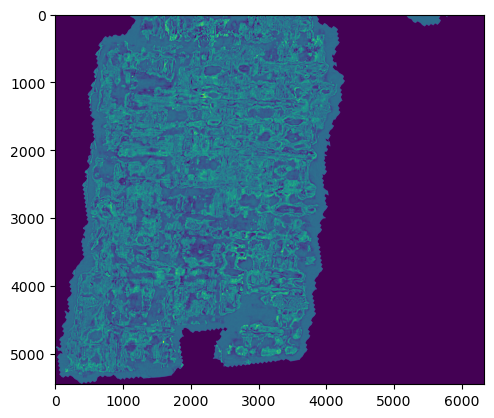

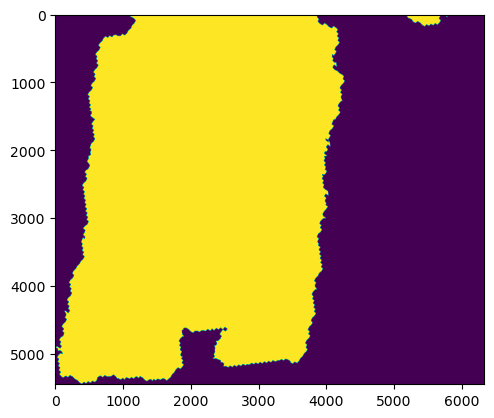

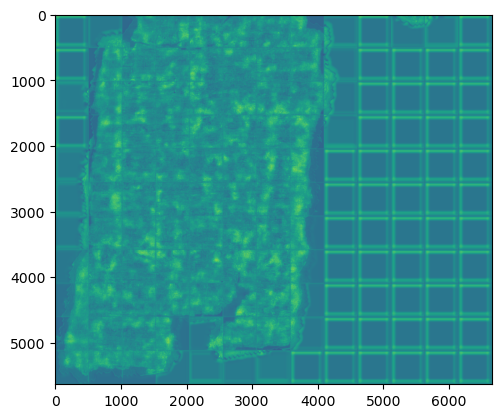

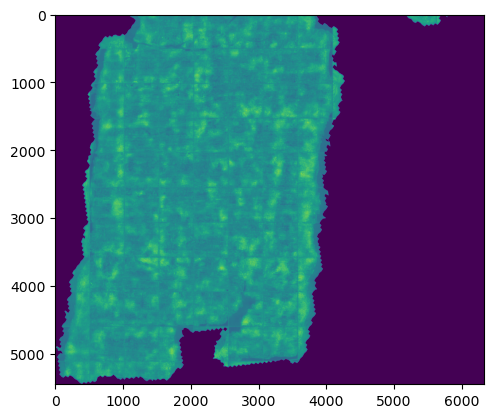

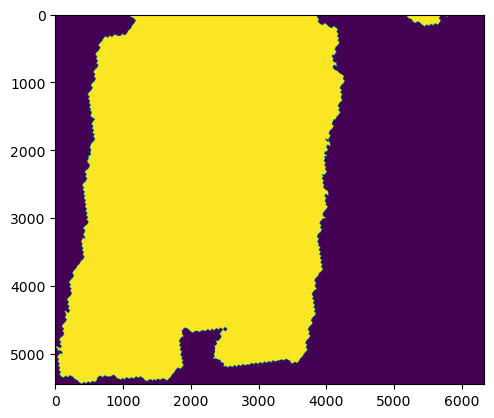

/kaggle/input/vesuvius-challenge-ink-detection/test/a


100%|██████████| 65/65 [00:32<00:00,  2.00it/s]


(65, 2727, 6330)


100%|██████████| 78/78 [00:28<00:00,  2.77it/s]


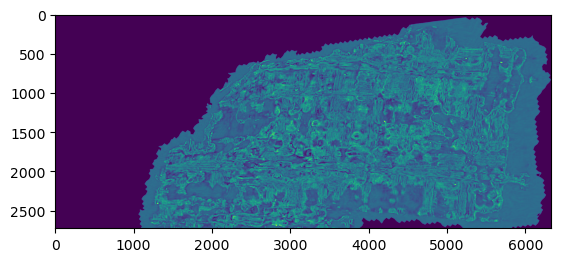

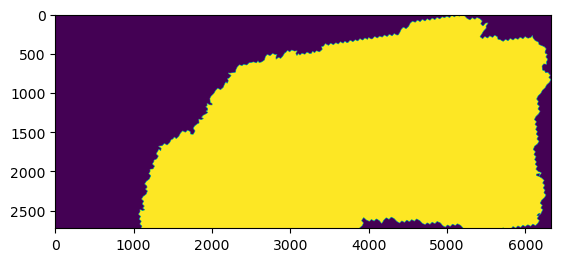

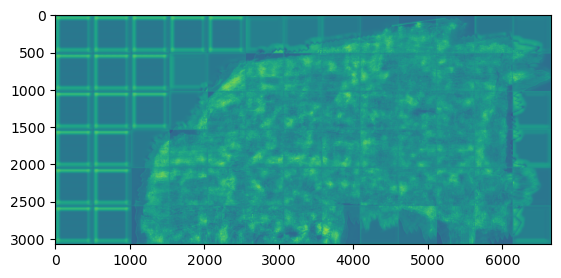

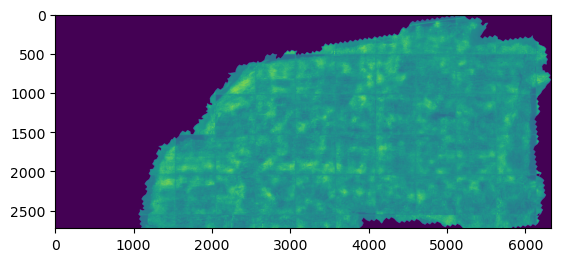

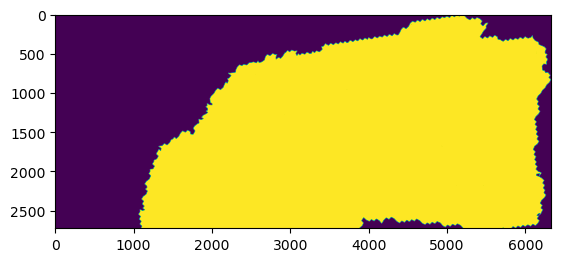

In [19]:
test_root_dir = DATA_DIR / "test/*"

pred_list = []
for f in glob.glob(str(test_root_dir)):
    print(f)
    pred_tile_img = predict(Path(f))

    plt.imshow(pred_tile_img)
    plt.show()

    if is_train:
        plt.figure(figsize=(20, 20))
    plt.imshow(np.where(pred_tile_img > 0.15, 1, 0))
    plt.show()

    starts_ix, lengths = rle(pred_tile_img, thr=0.4)
    inklabels_rle = " ".join(map(str, sum(zip(starts_ix, lengths), ())))
    inklabels_rle

    pred_list.append({"Id": str(f).split("/")[-1], "Predicted": inklabels_rle})

In [20]:
pd.DataFrame(pred_list).to_csv("submission.csv", index=False)